# Analysis of the Ethereum Blockchain Arbitrages and Liquidations

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Collection

The data consists of a list of arbitrage transactions, liquidations, block features which are stored on a postgres db.
Additionally, general features of the blockchain e.g. number of protocol usages in the transactions are stored in the db directory.
The arbitrage transactions were collected using calls to multiple Erigon RPC endpoints.

The first collection of data is from block 15200000 to 15500000 or from Jul-23-2022 04:32:35 PM +UTC to Sep-09-2022 01:39:42 AM +UTC.
These blocks are pre-merge blocks. The next collection will analyse the post-merge blocks.

First, we must connect to our database.

In [2]:
# Connect to db
from sqlalchemy import create_engine, text
from db import get_inspect_database_uri

conn = create_engine(get_inspect_database_uri()).connect()

# Arbitrage Analysis

## Data Loading and Cleaning

In [3]:
query = "SELECT * FROM arbitrages WHERE block_number BETWEEN 15200000 AND 15500000"
arb_df = pd.DataFrame(conn.execute(text(query)))
arb_df.set_index('id', inplace=True)
arb_df['timestamp'] = pd.to_datetime(arb_df['timestamp'])
arb_df = arb_df.sort_values('block_number')

In [4]:
arb_df.head()

,transaction_hash,block_number,timestamp,account_address,status,contracts_address,input_tokens_address,input_tokens_amount,output_tokens_address,output_tokens_amount,protocols,gas_price,gas_usage,block_position,profit_amount
id,,,,,,,,,,,,,,,
34,0xd39500706630fb26ea405ce04d7b5884df0866cb1a1c...,15200022,2022-07-23 21:08:45,0xd8c7031da609a6e201e038dd11c97d7f26f1d572,True,"{0xfca9090d2c91e11cc546b0d7e4918c79e0088194,0x...","{0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x...","{5120123648171978000,10837504868.0,7798609065.0}","{0x70e8de73ce538da2beed35d14187f6959a8eca96,0x...","{10837504868.0,7798609065.0,5133779858359948000}",{uniswap_v3},163839,68917,0,1.365621e+16
35,0x63c9c17d97c181b8819783b599a59940a786b5bd2bb6...,15200028,2022-07-23 21:09:18,0xd7c09e006a2891880331b0f6224071c1e890a98a,True,"{0x2c51eaa1bcc7b013c3f1d5985cdcb3c56dc3fbc1,0x...","{0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x...","{240470594654432770,22176822844245777000000}","{0x2d94aa3e47d9d5024503ca8491fce9a2fb4da198,0x...","{22176822844245777000000,248404143686549860}",{uniswap_v2},229745,136481,63,7.933549e+15
37,0xc9c502aec6b07d452ed4ce1e35c20e6cea0cda91e21a...,15200029,2022-07-23 21:09:57,0x5aa3393e361c2eb342408559309b3e873cd876d6,True,"{0xb404057ee4b1d7359ca5a57ac1c020b74c23e56b,0x...","{0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x...","{1906092123352685000,105673083691328340000}","{0x50d1c9771902476076ecfc8b2a83ad6b9355a4c9,0x...","{105673083691328340000,1939547111027948800}","{uniswap_v3,uniswap_v2}",947727,65768,33,3.345499e+16
36,0x2eb09482b29b2d32a240142dee1e7ec6288719c7f049...,15200029,2022-07-23 21:09:57,0xe8c060f8052e07423f71d445277c61ac5138a2e5,True,"{0x06db071bebeb0570a8f3aa0e49238140bedc268f,0x...","{0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x...","{203776686158774270,2011097854535.0,1272233986...","{0x53fd2342b43ecd24aef1535bc3797f509616ce8c,0x...","{2011097854535.0,12722339869926854000000,22747...",{uniswap_v2},474200,37474,37,2.369401e+16
38,0x7acd0000e5e346c66e58aac81c4f48ad6022c6a0184c...,15200034,2022-07-23 21:11:19,0xd8c7031da609a6e201e038dd11c97d7f26f1d572,True,"{0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,0x...","{0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x...","{6483562585462506000,9898566457.0,120839032289...","{0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x...","{9898566457.0,120839032289753.0,64965197108999...",{uniswap_v3},156765,60038,1,1.295713e+16


In [5]:
arb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114160 entries, 34 to 106593
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   transaction_hash       114160 non-null  object        
 1   block_number           114160 non-null  int64         
 2   timestamp              114160 non-null  datetime64[ns]
 3   account_address        114160 non-null  object        
 4   status                 114160 non-null  bool          
 5   contracts_address      114160 non-null  object        
 6   input_tokens_address   114160 non-null  object        
 7   input_tokens_amount    114160 non-null  object        
 8   output_tokens_address  114160 non-null  object        
 9   output_tokens_amount   114160 non-null  object        
 10  protocols              114160 non-null  object        
 11  gas_price              114160 non-null  int64         
 12  gas_usage              114160 non-null  int

## Status Analysis

Get the success rate of each address and protocol.

In [6]:
def count_features_grouped_by(df: pd.DataFrame, condition: str, _by: [str], features: [str]) -> pd.DataFrame:
    return df.loc[eval(condition)].groupby(by=_by).count().reset_index()[features]

### By Address

Get the success rate of each address

In [7]:
address_success_rate = arb_df.groupby('account_address')['status'].mean()
print('Success rate of each address:')
address_success_rate.head()

Success rate of each address:


account_address
0x0000000000000eb4ec62758aae93400b3e5f7f18    1.000000
0x000000000000660def84e69995117c0176ba446e    0.846154
0x0000000000007f150bd6f54c40a34d7c3d5e9f56    1.000000
0x0000000000036414940324055c43e75f56b7d016    1.000000
0x00000000000970375ff38f05eb9d6db32ae40708    0.666667
Name: status, dtype: float64

### By Protocol
Get the success rate of each address


In [8]:
# Split the protocols column into separate columns for each protocol
protocols_df = arb_df["protocols"].str.replace("[{}]", "", regex=True).str.get_dummies(sep=",")

# Concatenate the status column and the protocol columns
merged_df = pd.concat([arb_df["status"], protocols_df], axis=1)

# Calculate the success rate for each protocol
rates_df = merged_df.mean()
rates_df = rates_df.drop("status")

rates_df

balancer_v1    0.099974
bancor         0.000044
curve          0.006289
uniswap_v2     0.852260
uniswap_v3     0.439813
dtype: float64

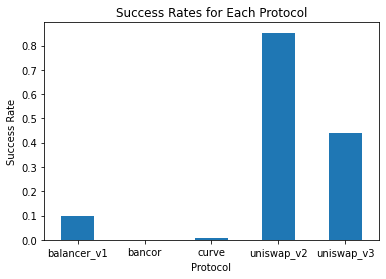

In [9]:
rates_df.plot(kind="bar", rot=0)
plt.title("Success Rates for Each Protocol")
plt.xlabel("Protocol")
plt.ylabel("Success Rate")
plt.show()

## Gas Usage Analysis

### Distribution

### Average gas usage per block
Compare average gas price for arbitrage transactions in each block with the total average gas price of that block.

First, load the blocks data.

In [10]:
# TODO: Log-transformation for heavy-tailed features
query = "SELECT * FROM blocks WHERE block_number BETWEEN 15200000 AND 15500000"
block_df = pd.DataFrame(conn.execute(text(query)))
block_df.head()

,block_number,avg_gas_price,avg_gas_usage
0,15350000,2.721346e+10,147368.451923
1,15350001,2.254700e+10,132315.841629
2,15350002,2.462672e+10,143398.263889
3,15350003,1.947772e+10,193935.637097
4,15350004,2.215424e+10,159431.977011


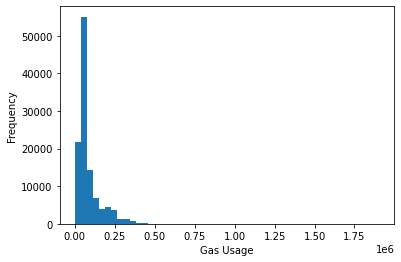

In [11]:
# Gas usage distribution

plt.hist(arb_df['gas_usage'], bins=50)
plt.xlabel('Gas Usage')
plt.ylabel('Frequency')
plt.show()

### Compared with all transactions

In [12]:
avg_gas_per_block = arb_df.groupby('block_number')['gas_usage'].mean()

In [13]:
# merge the average gas usage per block with the blocks_df dataframe
merged_df = pd.merge(block_df, avg_gas_per_block, on='block_number', how='inner')
merged_df.sort_values(by='block_number')

,block_number,avg_gas_price,avg_gas_usage,gas_usage
21,15200022,4.153248e+10,134339.764151,68917.0
22,15200028,2.738264e+10,200588.850000,136481.0
23,15200029,3.027934e+10,159324.673966,51621.0
24,15200034,4.212785e+10,155170.612903,60038.0
25,15200042,3.362009e+10,124875.841837,65111.0
...,...,...,...,...
65184,15499977,1.275421e+10,150213.633094,41032.0
65185,15499983,2.279058e+10,173226.878453,124695.0
65186,15499984,2.380291e+10,138621.292237,86905.0
65187,15499989,2.014510e+10,156501.361204,146233.0


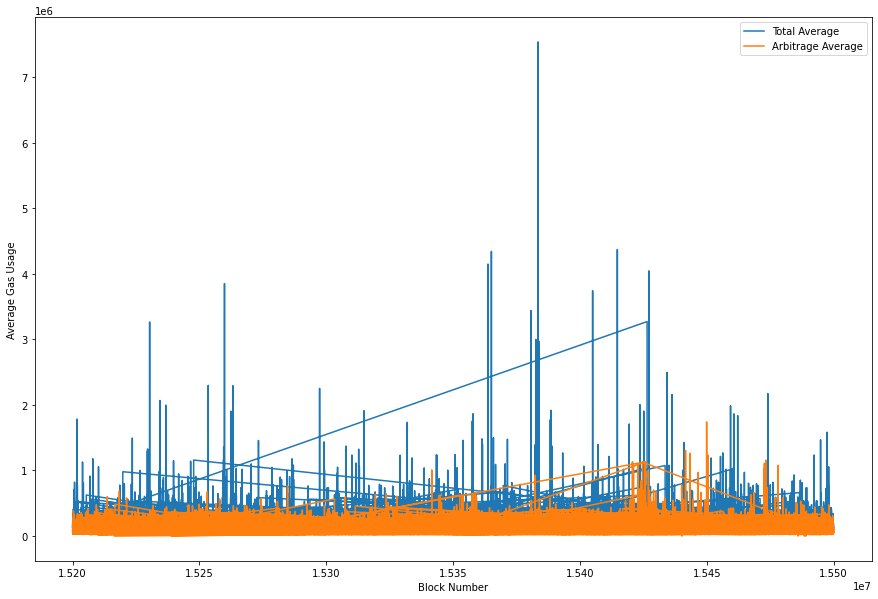

In [14]:
# plot the comparison of average gas usage per block with total average
plt.figure(figsize=(15, 10))
plt.plot(merged_df['block_number'], merged_df['avg_gas_usage'], label='Total Average')
plt.plot(merged_df['block_number'], merged_df['gas_usage'], label='Arbitrage Average')
plt.xlabel('Block Number')
plt.ylabel('Average Gas Usage')
plt.legend()
plt.show()

## Gas Price Analysis

### Distribution

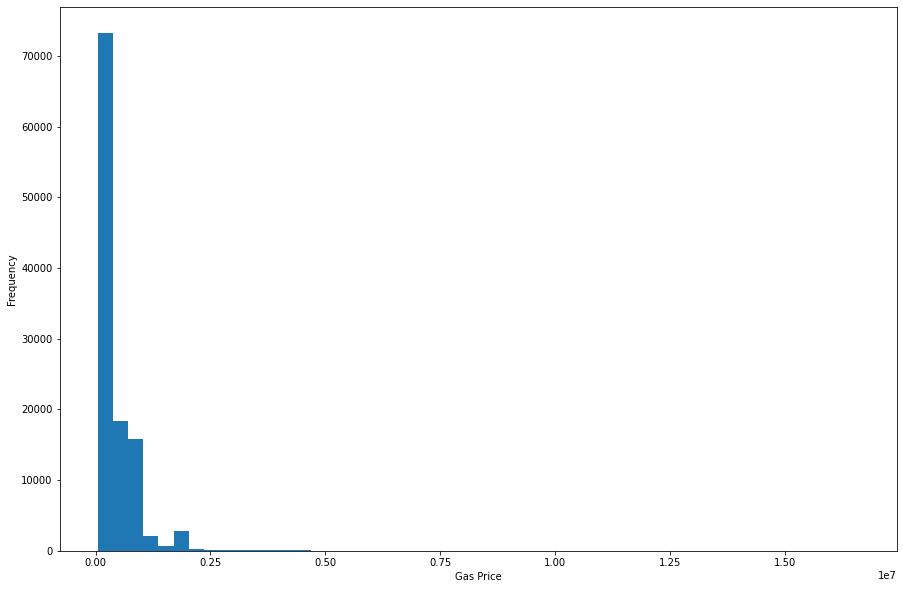

In [15]:
# Gas usage distribution

plt.figure(figsize=(15, 10))
plt.hist(arb_df['gas_price'], bins=50)
plt.xlabel('Gas Price')
plt.ylabel('Frequency')
plt.show()

### Compared with all transactions

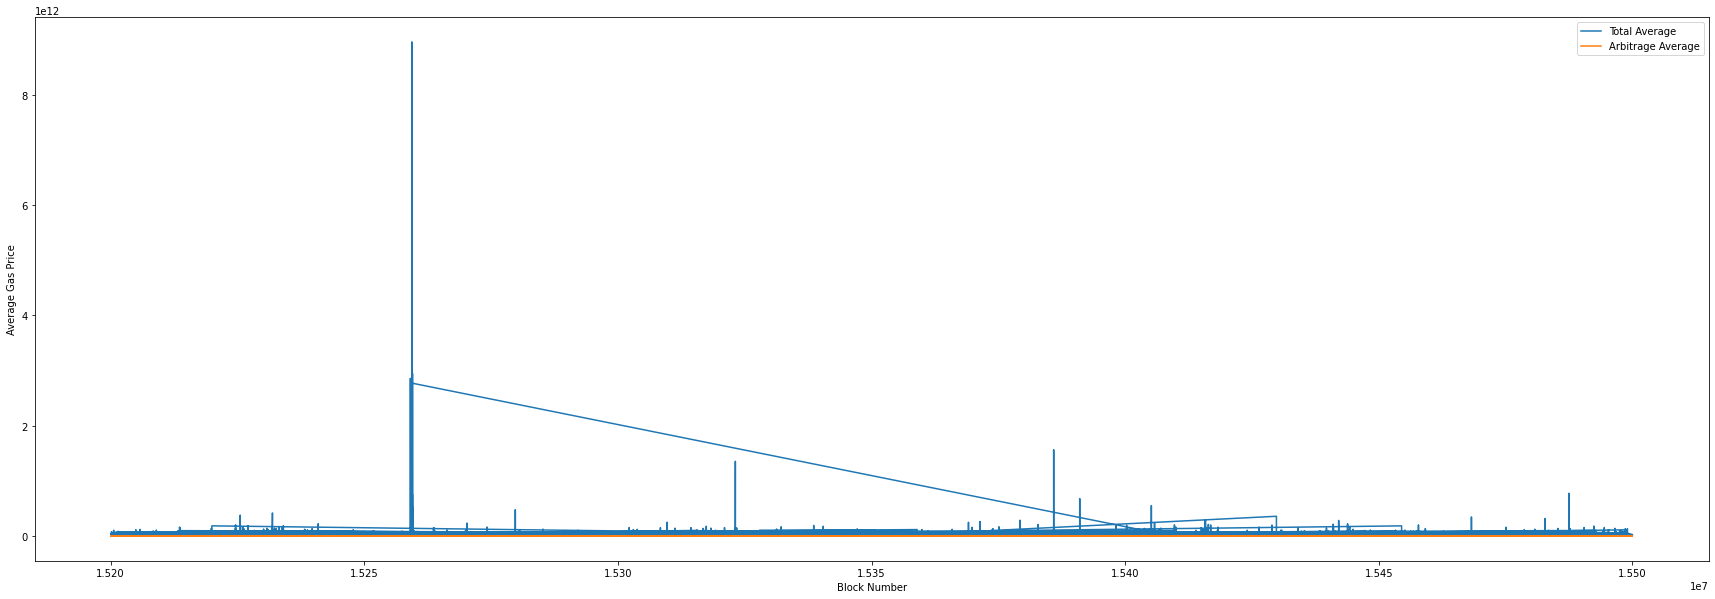

In [16]:
avg_gas_per_block = arb_df.groupby('block_number')['gas_price'].mean()

# merge the average gas price per block with the blocks_df dataframe
merged_df = pd.merge(block_df, avg_gas_per_block, on='block_number', how='inner')
merged_df.sort_values(by='block_number')

# plot the comparison of average gas usage per block with total average
plt.figure(figsize=(30, 10))
plt.plot(merged_df['block_number'], merged_df['avg_gas_price'], label='Total Average')
plt.plot(merged_df['block_number'], merged_df['gas_price'], label='Arbitrage Average')
plt.xlabel('Block Number')
plt.ylabel('Average Gas Price')
plt.legend()
plt.show()

# Analysis of the Tokens

In the first part, we show the most used tokens for profit in arbitrage.
Note that in an arbitrage transaction there might be several tokens involved but in the end the arbitrageur gains profit from a single token (this is the most basic analysis of arbitrage transactions, it's possible that the user gains profit from multiple tokens which occur in more complex arbitrages).

In [17]:
from collections import Counter


def _token_use(token_column: str):
    all_sets = pd.concat([arb_df[token_column]])
    all_strings = [string for set_ in all_sets for string in set_.split(',')]
    counts = Counter(all_strings)

    return pd.DataFrame(counts.values(), index=counts.keys())

In [18]:
# Replace the { and } characters in the relevant columns with an empty string using the str.replace method.

list_columns = ['contracts_address', 'input_tokens_address', 'input_tokens_amount', 'output_tokens_address',
                'output_tokens_amount', 'protocols']

for column in list_columns:
    arb_df[column] = arb_df[column].str.replace('[{}]', '', regex=True)

In [19]:
input_tokens = _token_use('input_tokens_address')
output_tokens = _token_use('output_tokens_address')

### Difference between input and output degrees of arbitrage transactions

In [20]:
any(input_tokens - output_tokens != 0)

False

The input and output degrees of the tokens are equal.

### Transaction Degree Analysis
Now, let's check the degree of arbitrage transactions i.e. the number of different tokens used in each transaction.

In [21]:
def get_transactions_degree():
    input_tokens_degree = pd.DataFrame(columns=['transaction_hash', 'degree'])
    output_tokens_degree = pd.DataFrame(columns=['transaction_hash', 'degree'])

    # Get degrees for output tokens
    output_tokens_degree['transaction_hash'] = arb_df['transaction_hash']
    output_tokens_degree['degree'] = arb_df['output_tokens_address'].str.count(',') + 1

    # Get degrees for input tokens
    input_tokens_degree['transaction_hash'] = arb_df['transaction_hash']
    input_tokens_degree['degree'] = arb_df['input_tokens_address'].str.count(',') + 1

    return input_tokens_degree, output_tokens_degree

In [22]:
tokens_degree, _ = get_transactions_degree()
tokens_degree

,transaction_hash,degree
id,,
34,0xd39500706630fb26ea405ce04d7b5884df0866cb1a1c...,3
35,0x63c9c17d97c181b8819783b599a59940a786b5bd2bb6...,2
37,0xc9c502aec6b07d452ed4ce1e35c20e6cea0cda91e21a...,2
36,0x2eb09482b29b2d32a240142dee1e7ec6288719c7f049...,3
38,0x7acd0000e5e346c66e58aac81c4f48ad6022c6a0184c...,3
...,...,...
106584,0x7de85a62d4ddcc9f6a25abb8700bb8ccd8f59dc3d36d...,2
106590,0xef788340c281084d5b89a923882761b3701710ce120c...,2
106591,0x4b3787dd2aa08c046462ade973471051e2a58dfbde36...,3


array([[<AxesSubplot:title={'center':'degree'}>]], dtype=object)

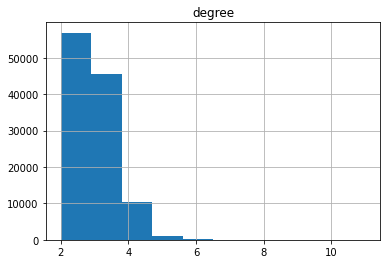

In [23]:
tokens_degree.hist('degree')

In [24]:
from tokens.name_tags import get_name_tag


def _get_name_tags(addresses):
    _public_name_tags = {}

    for address in addresses:
        _public_name_tags[address] = get_name_tag(_address=address)

    return _public_name_tags

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [25]:
# Get the 20 most used tokens
# Todo: profits?

most_used_tokens = input_tokens.nlargest(20, input_tokens.columns[0])

public_name_tags = _get_name_tags(most_used_tokens.index)

INFO:root:Already found: Wrapped Ether
INFO:root:Already found: Centre: USD Coin
INFO:root:Already found: Tether: USDT Stablecoin
INFO:root:Already found: ShibaSwap: BONE Token
INFO:root:Already found: Shiba Inu: SHIB Token
INFO:root:Already found: Maker: Dai Stablecoin
INFO:root:Already found: Wrapped BTC: WBTC Token
INFO:root:Already found: Shiba Inu: LEASH Token
INFO:root:Already found: Frax Finance: FRAX Token
INFO:root:Already found: FunFair Token
INFO:root:Already found: HEX.com: HEX Token
INFO:root:Already found: Unification: xFUND Token
INFO:root:Already found: Vow: VOW Token
INFO:root:Already found: Terra: LUNC Token
INFO:root:Already found: Synapse: SYN Token
INFO:root:Already found: StraitsX: XSGD Token
INFO:root:Already found: Angle Protocol: agEUR
INFO:root:Already found: Hedron: HDRN Token
INFO:root:Already found: Uniswap Protocol: UNI token
INFO:root:Already found: Animoca: REVV Token


In [26]:
def bar(ax, x, y, _rotation=75, _width=0.4):
    ax.bar(x, y, width=_width)
    ax.set_xticks( x)
    ax.set_xticklabels(x, rotation=_rotation)

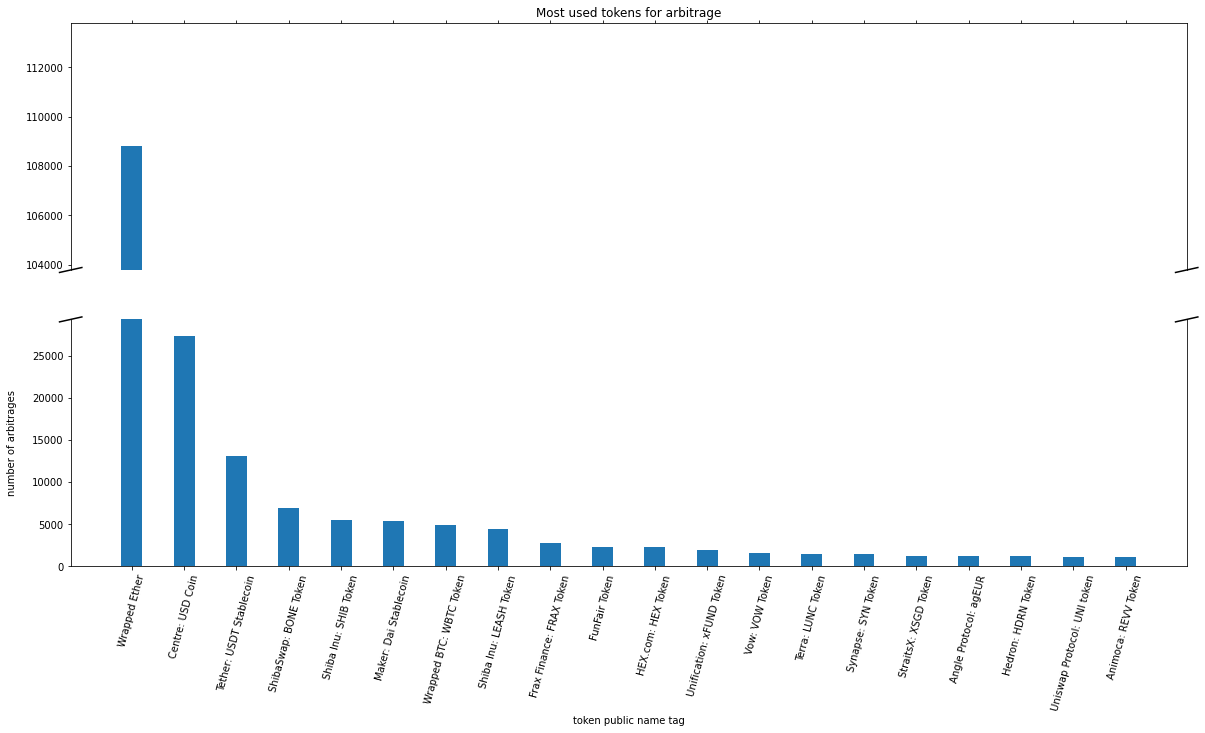

In [27]:
from matplotlib.transforms import ScaledTranslation

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

bar(ax1, most_used_tokens.index.map(public_name_tags), most_used_tokens.values.squeeze())
bar(ax2, most_used_tokens.index.map(public_name_tags), most_used_tokens.values.squeeze())

ax1.set_ylim(most_used_tokens.values[0] - 5000, most_used_tokens.values[0] + 5000)  # outliers only
ax2.set_ylim(0, most_used_tokens.values[1] + 2000)  # most of the data

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

################# Diagonal Lines #################

d = .010  # how big to make the diagonal lines in axes coordinates
kwargs = {'transform':ax1.transAxes, 'color':'k', 'clip_on':False}
ax1.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

###################################################

ax1.set_title("Most used tokens for arbitrage")

ax2.set_xlabel("token public name tag")
ax2.set_ylabel('number of arbitrages', labelpad=15)

plt.show()

The most used token is WETH. This is because arbitrageurs usually buy an arbitrage asset using ETH and gain the profit by selling them in ETH.
This might be because the WETH-TOKEN pools are more common in the exchanges.
The two latter places belong to stable coins: USDC and USDT
The three Shiba INu tokens: BONE, SHIB, and LEASH are also on top of the list.
Note that originally we only stored and counted the profit token which is usually WETH. But as mentioned before, the arbitrage opportunity is not a result of instability in WETH, rather in the instability of a certain token which is then exploited using the WETH pool.


In [ ]:
"""
TODO:
    Get the ration of transactions for the address using db/addresses
    Get the most used contracts (check them if they are pools)
    Time-series analysis on the transactions (their frequency)
        Transaction / day?
        Address activity
        Protocol activity
        Token activity
"""

## Active Addresses Analysis

### Most Active Addresses

In this part we take a look at the most active arbitrageurs i.e. the addresses that have the largest number of arbitrage transactions.
We can use this data along with the most profitable addresses to see if there is any relation between number of transactions and profit.

The distribution of the number of transactions by address

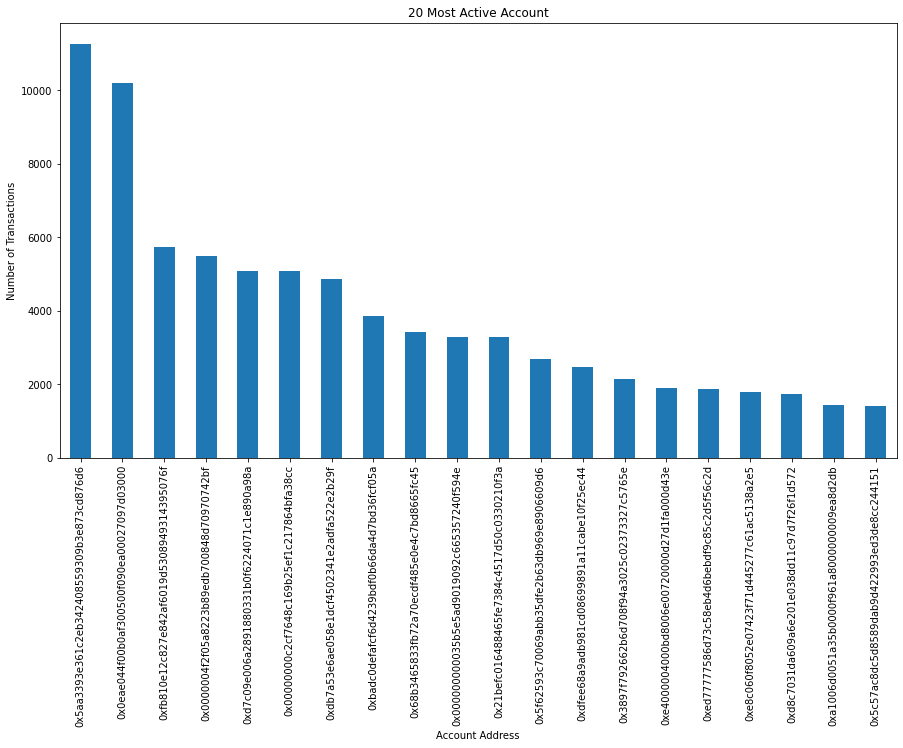

In [49]:
# Count the number of transactions for each account address
transactions_by_address = arb_df['account_address'].value_counts()

# Plot the results as a bar chart
plt.figure(figsize=(15, 8))
transactions_by_address.head(20).plot(kind='bar')
plt.title('20 Most Active Account')
plt.xlabel('Account Address')
plt.ylabel('Number of Transactions')
plt.show()

### Distribution

The distribution of the number of transactions per address.

Note: Addresses with less than 5 transactions were removed. There were around 300 accounts.

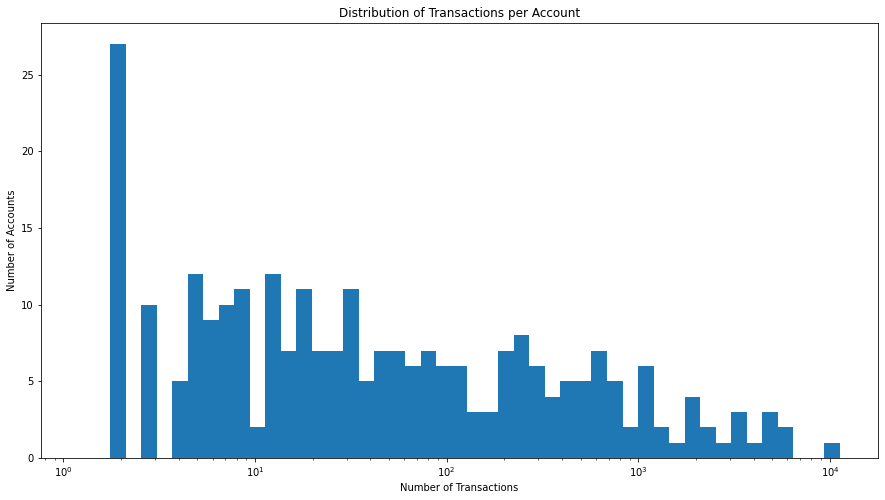

In [59]:
# Group by account address and count the number of transactions
transactions_per_account = arb_df.groupby(['account_address']).size()

# Define custom bin edges
bin_edges = np.logspace(np.log10(1), np.log10(transactions_per_account.max()), 51)

# Remove the first bin edge
bin_edges = bin_edges[1:]

# Plot the distribution of transactions per account as a histogram
plt.figure(figsize=(15, 8))
plt.hist(transactions_per_account, bins=bin_edges)
plt.xscale('log')
plt.title('Distribution of Transactions per Account')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Accounts')
plt.show()

## Ratio of arbitrage transactions
The percentage of transactions that are arbitrage for each address

### Load Accounts data
Get number of transactions of each address

In [ ]:
from datetime import datetime

adr_db_path = "../db/addresses/"
number_of_files = len(os.listdir(adr_db_path))
column_names = ['txn_cnt_' + str(i) for i in range(number_of_files)]
adr_df = pd.DataFrame(columns=['address'], dtype='object')

i = 0
for file_name in os.listdir(adr_db_path):
    print(datetime.now(), file_name)
    temp_adr_df = pd.read_csv(adr_db_path + file_name, names=['address', 'txn_cnt_' + str(i)], index_col=False)
    temp_adr_df = temp_adr_df.groupby(by=['address']).sum()
    adr_df = adr_df.merge(temp_adr_df, how='outer', on='address')
    print(datetime.now(), file_name, 'end')
    i += 1

adr_df.fillna(0)
adr_df['txn_cnt'] = adr_df[column_names].sum(axis=1)
adr_df.drop(columns=column_names, inplace=True)
adr_df

In [ ]:
adr_df[adr_df['txn_cnt_0'] > np.mean(adr_df[adr_df['txn_cnt_0'] > 1])].hist()

# TODO
## Time Analysis of Arbitrage Transactions
### Frequency for the Blockchain

#### Monthly

In [ ]:
month_df = arb_df.groupby([arb_df['time_stamp'].dt.year, arb_df['time_stamp'].dt.month]).count()[
    ['block_number', 'transaction_hash']]
month_df

In [ ]:
month_df.describe()

In [ ]:
del month_df

#### Daily

In [ ]:
day_df = arb_df.groupby([arb_df['time_stamp'].dt.date]).count()[['block_number', 'transaction_hash']]
day_df

In [ ]:
day_df.describe()

In [ ]:
plt.plot(day_df['block_number'])
del day_df
plt.show()

In [ ]:
# Hourly
hour_df = arb_df.groupby([arb_df['time_stamp'].dt.date, arb_df['time_stamp'].dt.hour]).count()[
    ['block_number', 'transaction_hash']]
hour_df

In [ ]:
hour_df.describe()

In [ ]:
hour_list = list(hour_df['block_number'])

grp_val = 24

plt.plot([sum(hour_list[i:i + grp_val]) for i in range(0, len(hour_list), grp_val)])
plt.show()

In [ ]:
del hour_df

In [ ]:
# By Minute
minute_df = \
    arb_df.groupby(
        [arb_df['time_stamp'].dt.date, arb_df['time_stamp'].dt.hour, arb_df['time_stamp'].dt.minute]).count()[
        ['block_number', 'transaction_hash']]
minute_df

In [ ]:
minute_df.describe()

In [ ]:
del minute_df

### Frequency for Each Account

In [ ]:
# Daily Frequency
acc_freq_df = arb_df.loc[arb_df['account_address'].isin(most_active_arbitrageurs.index)].groupby(
    [arb_df['account_address'], arb_df['time_stamp'].dt.date]).count()[['block_number', 'transaction_hash']]
acc_freq_df

In [ ]:
len(acc_freq_df.index.get_level_values(0).unique())

### Frequency for Each Protocol

### Block position

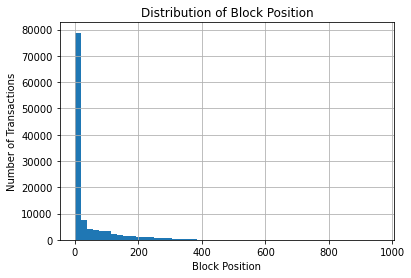

In [40]:
arb_df['block_position'].hist(bins=50)
plt.title('Distribution of Block Position')
plt.xlabel('Block Position')
plt.ylabel('Number of Transactions')
plt.show()

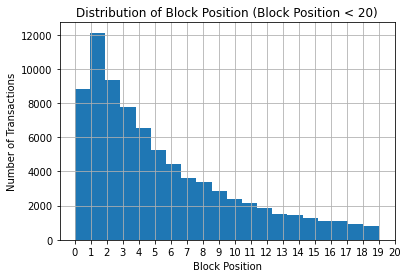

In [45]:
# Filter the data to include only block positions less than 20
filtered_df = arb_df[arb_df['block_position'] < 20]

# Plot the distribution of block_position less than 20 as a histogram
filtered_df['block_position'].hist(bins=20)
plt.title('Distribution of Block Position (Block Position < 20)')
plt.xlabel('Block Position')
plt.ylabel('Number of Transactions')
plt.xticks(np.arange(21))
plt.show()

## Most used protocols

In [ ]:
# Parse the protocols column and group by protocol
protocols_df = arb_df['protocols'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('protocol')
protocols_df = protocols_df.join(arb_df['account_address'])
protocols_df = protocols_df.groupby(['protocol']).count().reset_index()

# Plot the results as a bar chart
protocols_df.plot(x='protocol', y='account_address', kind='bar')
plt.title('Distribution of Transactions by Protocol')
plt.xlabel('Protocol')
plt.ylabel('Number of Transactions')
plt.show()

In [ ]:
# TODO: normalise